In [1]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = '/content/drive/My Drive/DL_Class/medical_proj/data/train'
valid_path = '/content/drive/My Drive/DL_Class/medical_proj/data/valid'
test_path = '/content/drive/My Drive/DL_Class/medical_proj/data/test'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['melanoma', 'nevus', 'seborrheic_keratosis'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['melanoma', 'nevus', 'seborrheic_keratosis'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['melanoma', 'nevus', 'seborrheic_keratosis'], batch_size=32)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


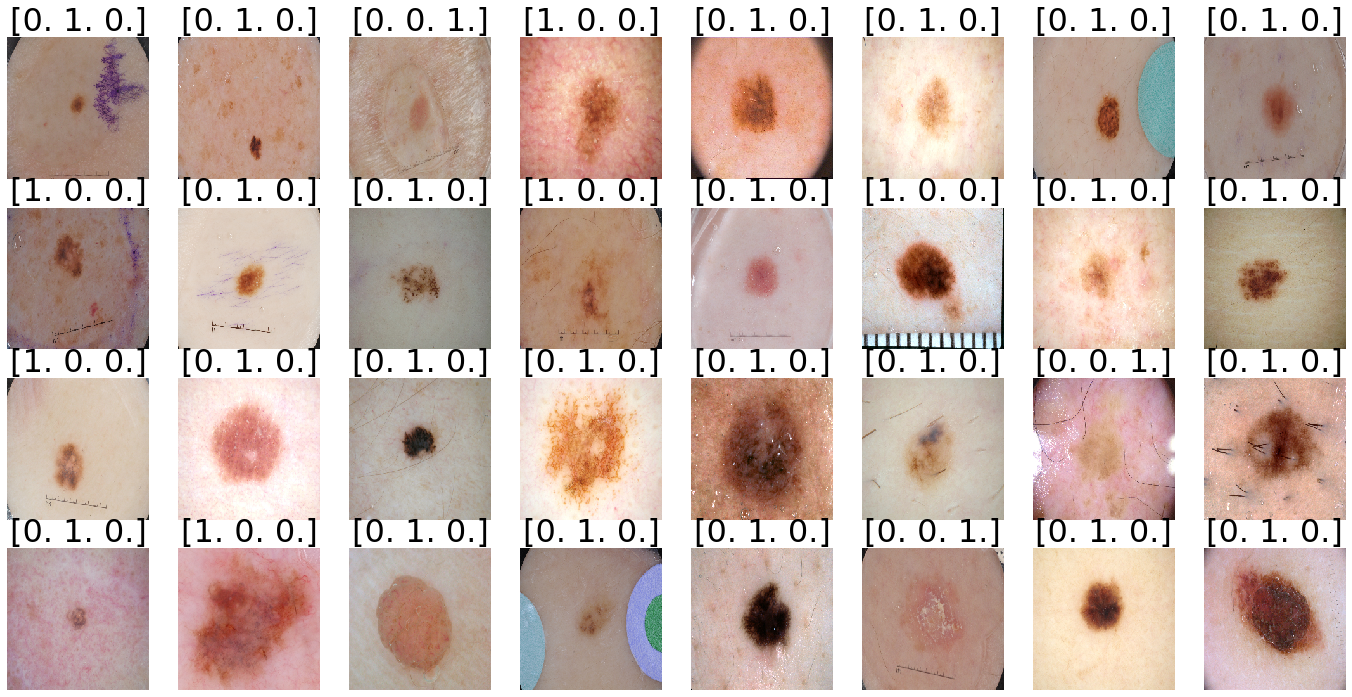

In [35]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None, subtitle=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
            
        plt.imshow(ims[i], interpolation=None if interp else 'none')
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [4]:
[resnet101_model = tensorflow.keras.applications.ResNet101(weights='imagenet', 
                                                          include_top=False, 
                                                          input_tensor=Input(shape=(224,224,3)))

In [5]:
resnet101_model.layers

In [6]:
for layer in resnet101_model.layers[:-4]:
    layer.trainable = False

In [7]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(resnet101_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# changed to 3 from 2
model.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 145,422,723
Trainable params: 103,819,267
Non-trainable params: 41,603,456
_________________________________________________________________


In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_batches,
      steps_per_epoch=train_batches.samples/train_batches.batch_size ,
      epochs=5,
      validation_data=valid_batches,
      validation_steps=valid_batches.samples/valid_batches.batch_size,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
63/62 [==============================] - 1271s 20s/step - loss: 3.6632 - acc: 0.6300 - val_loss: 0.8992 - val_acc: 0.6533
Epoch 2/5
63/62 [==============================] - 1074s 17s/step - loss: 0.8721 - acc: 0.7635 - val_loss: 1.1593 - val_acc: 0.6333
Epoch 3/5
63/62 [==============================] - 1068s 17s/step - loss: 0.6278 - acc: 0.8285 - val_loss: 1.0344 - val_acc: 0.7000
Epoch 4/5
63/62 [==============================] - 1043s 17s/step - loss: 0.4645 - acc: 0.8705 - val_loss: 2.0720 - val_acc: 0.6933
Epoch 5/5
63/62 [==============================] - 1052s 17s/step - loss: 0.3902 - acc: 0.8925 - val_loss: 1.6439 - val_acc: 0.6933


In [9]:
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

In [10]:
model.save("/content/drive/My Drive/DL_Class/medical_proj/models/tf_resnet101_xfer learn/tf_resnet101.hdf5")

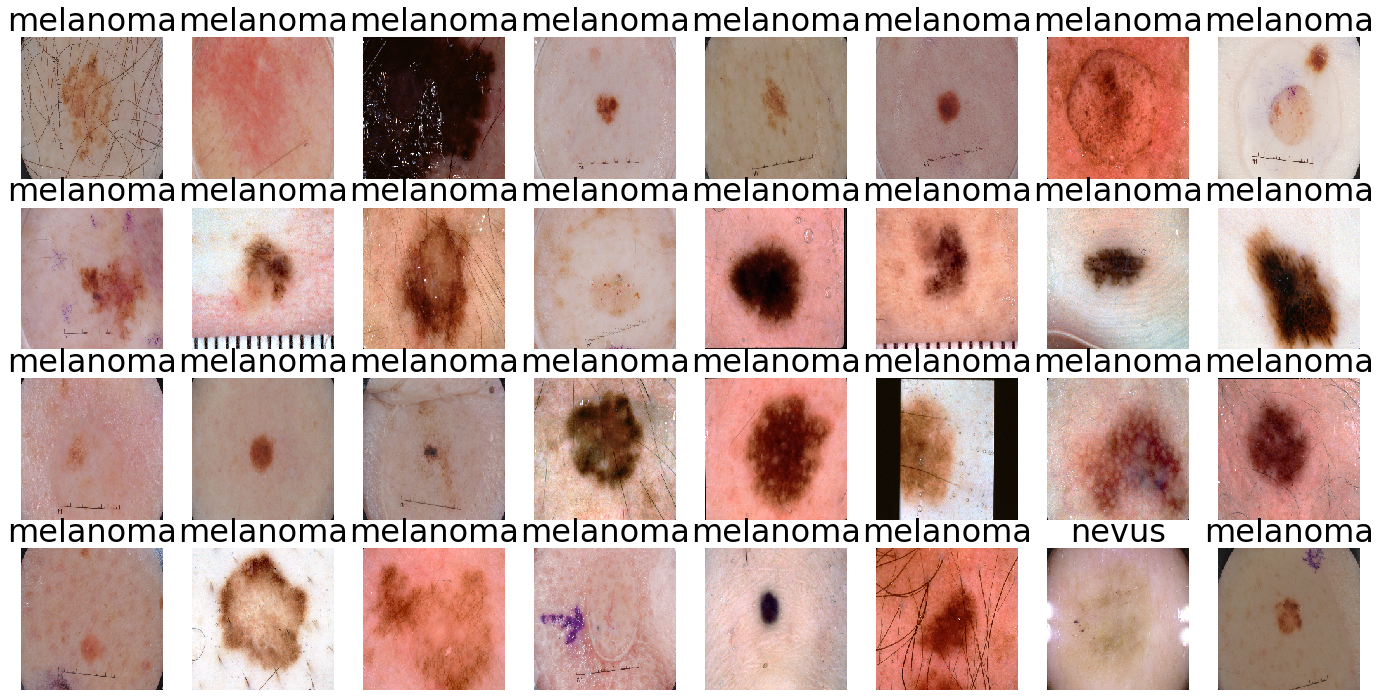

In [44]:
import pandas as pd
def to_label(value):
    if value==0:
        return 'melanoma'
    elif value==1:
        return 'nevus'
    elif value==2:
        return 'sk'
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:]
df['predicted'] = np.round(predictions[:,2])
df['predicted_labels']=df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['predicted_labels'])

In [45]:
df

,actual,predicted,predicted_labels
0,0.0,0.0,melanoma
1,0.0,0.0,melanoma
2,0.0,0.0,melanoma
3,0.0,0.0,melanoma
4,0.0,0.0,melanoma
5,0.0,0.0,melanoma
6,0.0,0.0,melanoma
7,0.0,0.0,melanoma
8,0.0,0.0,melanoma
9,0.0,0.0,melanoma


In [47]:
test_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [23]:
test_batches.labels[3]

0

In [24]:
p= model.predict(test_imgs)


In [36]:
p

array([[9.1766703e-01, 8.2332738e-02, 1.6501588e-07],
       [7.9134703e-02, 6.6659826e-01, 2.5426701e-01],
       [2.2098504e-02, 5.6769431e-02, 9.2113209e-01],
       [5.7435479e-08, 1.0000000e+00, 4.7594473e-14],
       [5.1932420e-06, 9.9999475e-01, 1.0695279e-15],
       [8.5611176e-04, 9.9346197e-01, 5.6818901e-03],
       [7.5194095e-03, 9.9222237e-01, 2.5820243e-04],
       [7.4891729e-04, 9.9925047e-01, 6.3634138e-07],
       [9.0583076e-04, 9.1043007e-01, 8.8664100e-02],
       [1.0652603e-05, 9.9998939e-01, 1.2038381e-12],
       [2.1404536e-01, 7.8590244e-01, 5.2225525e-05],
       [9.9393097e-04, 9.9900609e-01, 2.7373320e-08],
       [5.1285775e-07, 9.9999952e-01, 2.4710911e-13],
       [6.1357886e-01, 3.7081701e-01, 1.5604070e-02],
       [3.6189705e-04, 1.6857961e-01, 8.3105850e-01],
       [9.7161353e-01, 2.8204625e-02, 1.8185013e-04],
       [3.7472905e-03, 9.9561900e-01, 6.3366041e-04],
       [4.4494262e-04, 9.9955505e-01, 9.6628304e-12],
       [2.3916606e-08, 9.999